# Basic Lego 

One piece of each type: pole, wing, 2x4 for MaskRCNN test run...



In [1]:
#!git clone https://github.com/tensorflow/tpu/


#from google.colab import drive
#drive.mount('/content/drive')

import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

import tensorflow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import cv2

#!ls "/content/drive/My Drive/"

root = "/home/will/projects/legoproj/"
ROOT_DIR = root + "nets/"
dataroot = root + "data/"


# Import Mask RCNN
sys.path.append(root)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log


from mrcnn.config import Config


!pip install pycocotools

import pycocotools
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
 
#drive.mount("/content/drive", force_remount=True)
%matplotlib inline

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_shapes3.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    



/home/will/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/will/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/will/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/will/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

## Configurations

In [3]:
class PiecesConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "pieces"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE="resnet50"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 + 1 + 1

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128,256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 20
    
    #MASK_SHAPE = [28,28]
    
    MASK_POOL_SIZE = 32
    MASK_SHAPE = [64, 64]

    # set number of epoch
    STEPS_PER_EPOCH = 100

    # set validation steps 
    VALIDATION_STEPS = 40
    
    MAX_GT_INSTANCES = 10
    
    BATCH_SIZE = 32
    
    
class InferenceConfig(PiecesConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inf_config = InferenceConfig()
    
config = PiecesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 32
MASK_SHAPE              

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [8]:
class LegoDataset(utils.Dataset):
  
    def load_lego(self, subset, class_ids=None,
                  class_map=None, return_coco=False):
        """Load a subset of the COCO dataset.
        dataset_dir: The root directory of the COCO dataset.
        subset: What to load (train, val, minival, valminusminival)
        year: What dataset year to load (2014, 2017) as a string, not an integer
        class_ids: If provided, only loads images that have the given classes.
        class_map: TODO: Not implemented yet. Supports maping classes from
            different datasets to the same class ID.
        return_coco: If True, returns the COCO object.
        auto_download: Automatically download and unzip MS-COCO images and annotations
        """
        
        coco = COCO(dataroot + "{}.json".format(subset))

        image_dir = dataroot + "{}_oneofeach".format(subset)

        print(sorted(coco.getCatIds()))
        
        class_ids = coco.getCatIds()

        # All images or a subset?
        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(coco.getImgIds(catIds=[id])))
                
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
          
            # All images
            image_ids = list(coco.imgs.keys())
            
        print(image_ids)

        # Add classes
        for i in class_ids:
            self.add_class("coco", i, coco.loadCats(i)[0]["name"])
            
        print(coco.imgs)
        
        # Add images
        for i in image_ids:
            self.add_image(
                "coco", image_id=i,
                path=os.path.join(image_dir, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
        
            
        if return_coco:
            return coco



    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(CocoDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "coco.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(CocoDataset, self).load_mask(image_id)

    def image_reference(self, image_id):
        """Return a link to the image in the COCO Website."""
        info = self.image_info[image_id]
        if info["source"] == "coco":
            return "http://cocodataset.org/#explore?id={}".format(info["id"])
        else:
            super(CocoDataset, self).image_reference(image_id)

    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m
         
       
        

In [9]:
#Training dataset
dataset_train = LegoDataset()
dataset_train.load_lego("train")
dataset_train.prepare()

# Validation dataset
dataset_val = LegoDataset()
dataset_val.load_lego("val")
dataset_val.prepare()

dataset_test = LegoDataset()
dataset_test.load_lego("test")
dataset_test.prepare()


loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
[1, 2, 3]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 2

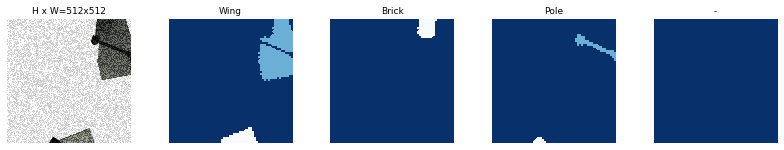

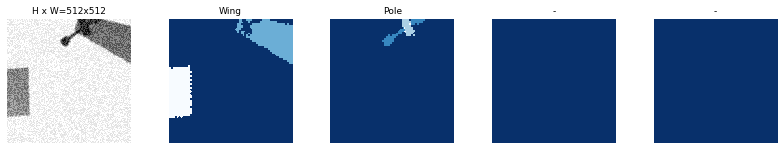

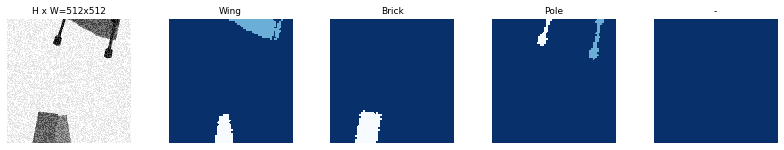

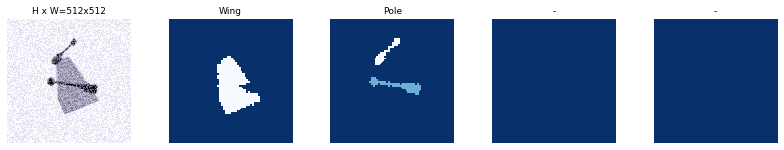

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=5 * config.LEARNING_RATE, 
            epochs=7, 
            layers='4+')


Starting at epoch 0. LR=0.005

Checkpoint Path: /home/will/projects/legoproj/nets/logs/pieces20191105T1234/mask_rcnn_pieces_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_branch2c         (Conv2D

/home/will/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/will/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/will/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/7
 99/100 [============================>.] - ETA: 0s - loss: 1.6925 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.5469 - mrcnn_class_loss: 0.3396 - mrcnn_bbox_loss: 0.4721 - mrcnn_mask_loss: 0.3143

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 112s 1s/step - loss: 1.6882 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5457 - mrcnn_class_loss: 0.3383 - mrcnn_bbox_loss: 0.4710 - mrcnn_mask_loss: 0.3136 - val_loss: 1.2660 - val_rpn_class_loss: 0.0124 - val_rpn_bbox_loss: 0.4518 - val_mrcnn_class_loss: 0.2236 - val_mrcnn_bbox_loss: 0.3083 - val_mrcnn_mask_loss: 0.2699
Epoch 2/7
100/100 [==============================] - 74s 743ms/step - loss: 1.1891 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4259 - mrcnn_class_loss: 0.2222 - mrcnn_bbox_loss: 0.2825 - mrcnn_mask_loss: 0.2473 - val_loss: 1.1723 - val_rpn_class_loss: 0.0103 - val_rpn_bbox_loss: 0.4784 - val_mrcnn_class_loss: 0.2065 - val_mrcnn_bbox_loss: 0.2375 - val_mrcnn_mask_loss: 0.2396
Epoch 3/7
100/100 [==============================] - 75s 747ms/step - loss: 1.0912 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4093 - mrcnn_class_loss: 0.1918 - mrcnn_bbox_loss: 0.2429 - mrcnn_mask_loss: 0.2372 - val_loss: 1.0594 - val_rpn_class_loss: 0.01

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
#model.train(dataset_train, dataset_val, 
#            learning_rate=config.LEARNING_RATE / 10,
#            epochs=5, 
#            layers="4+")

In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_1ofeach3.h5")
model.keras_model.save_weights(model_path)
print(model_path)


/home/will/projects/legoproj/nets/logs/mask_rcnn_1ofeach3.h5


## Detection

In [10]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inf_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_1ofeach3.h5")
#model_path = model.find_last()[1]

#print(model_path)

# Load trained weights (fill in path to trained weights here)
#assert model_path != "", "Provide path to trained weights"
#print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (5,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (5, 4)                min:  128.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 5)         min:    0.00000  max:    1.00000  bool


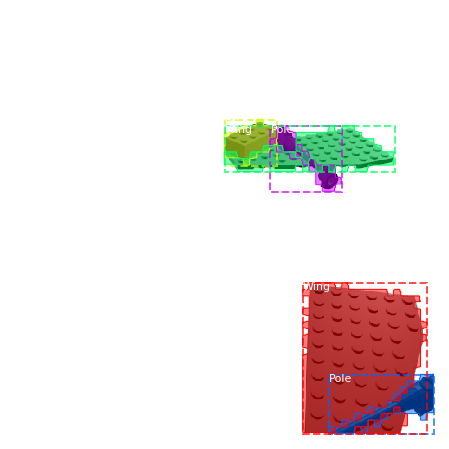

In [11]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inf_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


array([2, 1, 1, 3], dtype=int32)

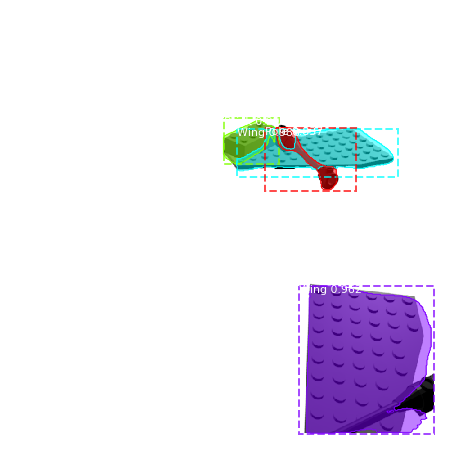

In [12]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())
r['scores']
r['class_ids']

Processing 1 images
image                    shape: (683, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  683.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


array([2, 1, 2, 3], dtype=int32)

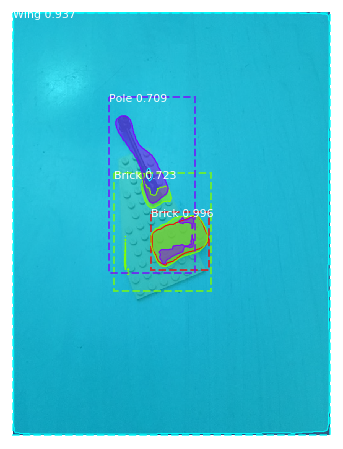

In [14]:
#img = cv2.imread("/home/will/projects/legoproj/data/combo1/combo1.png")
img = cv2.imread("/home/will/Downloads/ontable.jpeg")


results = model.detect([img], verbose=1)

r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())
r['scores']
r['class_ids']

## Evaluation

In [15]:
print(3/0)

import cv2
from google.colab.patches import cv2_imshow

mmask = r['masks'][:,:,1]
newimg = np.zeros((512, 512,3))

for y in range(512):
  for x in range(512):
    b = mmask[x][y]
    newimg[x][y] = (original_image[x][y])/255
    if not b:  
      newimg[x][y] = [0,0,0]
  
#print(original_image.shape)
#print(mmask.shape)
#res = cv2.bitwise_and(original_image,original_image,mask = newmask)
plt.imshow( newimg )




ZeroDivisionError: division by zero

In [ ]:

X_test = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
sizes_test = []
_test_ids = []

print('Getting and resizing test images ... ')
#sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    _test_ids.append([id_])
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    X_test[n] = img

In [ ]:
print("checking a test image with masks ...")
results = model.detect([X_test[7]], verbose=1)

r = results[0]
visualize.display_instances(X_test[7], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())


In [ ]:
# Run-length encoding for submission
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
  
  
def prob_to_rles(x):
   
    for i in range(0, len(x[1, 1, :])):
        y = x[:, :, i]
        yield rle_encoding(np.squeeze(y))

new_test_ids = []
rles = []

print(len(test_ids))

for n in range(0, len(test_ids)):

    results = model.detect([X_test[n]], verbose=0)
     
    r = results[0]

    number_of_masks = len(r['masks'][1, 1, :])
    
    pred_masks = np.zeros([sizes_test[n][0], sizes_test[n][1], number_of_masks], dtype=np.uint8)
   
    for m in range(0, number_of_masks):
        pred_mask_temp = r['masks'][:, :, m]
        pred_masks[:, :, m] = resize(np.squeeze(pred_mask_temp), (sizes_test[n][0], sizes_test[n][1]), mode='constant', preserve_range=True)
        
    # Handle occlusions
    occlusion = np.logical_not(pred_masks[:, :, -1]).astype(np.uint8)
    for i in range(number_of_masks-2, -1, -1):
        pred_masks[:, :, i] = pred_masks[:, :, i] * occlusion
        occlusion = np.logical_and(occlusion, np.logical_not(pred_masks[:, :, i]))
        
    rle = list(prob_to_rles(pred_masks))
        
            
    em = 0
    while (em < len(rle)):
          if len(rle[em]) == 1:
              print ("mask has one pixel")
          if len(rle[em]) == 0:
              print ("mask is empty. deleting mask")
              del rle[em]
          else:
              em = em + 1
    
    
    k = 0
    
    for m in range(0, len(rle)):
        while (k < len(rle[m]) ):
            if rle[m][k] + rle[m][k+1] >= sizes_test[n][0] * sizes_test[n][1]:
                print("Index was outside the bounds of the array.    index = ", rle[m][k] + rle[m][k+1], "    array size = ", sizes_test[n][0] * sizes_test[n][1] )
                rle[m][k+1] = sizes_test[n][0] * sizes_test[n][1] - rle[m][k] - 1
                #print("run length fixed ")
                print("run length fixed.    index = ", rle[m][k] + rle[m][k+1], "    array size = ", sizes_test[n][0] * sizes_test[n][1] )
                if rle[m][k+1] < 0:
                    print("run lngth is negative. deleting the index and run length   ")
                    del rle[m][k]
                    del rle[m][k]
                if rle[m][k] < 0:
                    print("index is negative. deleting the index and run length   ")
                    del rle[m][k]
                    del rle[m][k]
                    
           
                    
                 
                    
                #check that pixels are ordered 
                if rle[m][k] > rle[m][k+2]:
                   print ("pixel not ordered")
                
                #check that a pixel is not duplicated
                if rle[m][k] + rle[m][k+1] >= rle[m][k+2]:
                   print ("pixel duplicated")
                
            k = k + 2
    k = 0           
    for m in range(0, len(rle)):
        
        while (k < len(rle[m]) ):
            if rle[m][k] + rle[m][k+1] >= sizes_test[n][0] * sizes_test[n][1]:
                print("Index was outside the bounds of the array.    index = ", rle[m][k] + rle[m][k+1], "    array size = ", sizes_test[n][0] * sizes_test[n][1] )
            k = k + 2   
    
    rles.extend(rle)
    new_test_ids.extend(_test_ids[n] * len(rle))


# Create submission DataFrame

sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018.csv', index=False)

    

In [ ]:
files.download('sub-dsbowl2018.csv')